In [1]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from random import randint
import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

import torchvision
from torchvision.ops import box_iou


In [2]:
LABEL_CSV = Path("../data/cardiac_detection/rsna_heart_detection.csv")
IMAGE_CSV = Path("../data/cardiac_detection/processed/images")

In [3]:
data_df = pd.read_csv(LABEL_CSV)
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42,)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Length of train_df: {len(train_df)} | Length of val_df: {len(val_df)}")
train_df.head()

Length of train_df: 396 | Length of val_df: 100


,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,86,52,71,108,831d8a07-1024-42a3-af2c-181144351cab,224,224
1,heart,85,52,91,96,61008b44-a7ce-4870-b8e1-4f6f5c7df4d8,224,224
2,heart,92,66,80,96,c8111e21-a740-44c9-812a-a5f9982814c8,224,224
3,heart,89,74,102,91,81dca618-553d-4299-a4a0-e64f764bf69f,224,224
4,heart,88,68,80,95,8d85ff98-36a9-4763-9238-1fe184b8409e,224,224


In [4]:
img_name = train_df.iloc[0,5] + ".npy"
img_path = IMAGE_CSV / img_name
img = np.load(img_path)

In [5]:
# calculate mean and std.dev from all images
mean = 0.
std = 0.
for i in range(len(train_df)):
    img_name = train_df.iloc[i, 5] + ".npy"
    img_path = IMAGE_CSV / img_name
    img = np.load(img_path)
    mean += img.mean()
    std += img.std()
mean /= len(train_df)   # mean = mean / len(train_df)
std /= len(train_df)    # std = std / len(train_df)
print(f"Mean: {mean} | Std.Dev: {std}")

Mean: 0.49076118854561235 | Std.Dev: 0.23536666715988006


In [6]:
train_df.iloc[0,4]

108

In [7]:
class CardiacDatareader(Dataset):
    def __init__(self, df, aug=None):
        self.df = df
        self.aug = aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 5]
        img_data = np.load(IMAGE_CSV / f"{img_id}.npy").astype(np.float32)
        
        # bbox
        x = self.df.iloc[idx, 1]
        y = self.df.iloc[idx, 2]
        xmax = x + self.df.iloc[idx, 3]
        ymax = y + self.df.iloc[idx, 4]
        bbox = [x, y, xmax, ymax]
        label = ["heart"]

        if self.aug:
            bbox = bbox + label
            transformed = self.aug(image=img_data, bboxes=[bbox])
            img_data = transformed["image"]
            bbox = transformed["bboxes"][0]
            bbox = bbox[:4]
            
        img = img_data
        bbox = torch.tensor(bbox, dtype=torch.float32)

        # print(img.shape)
        return img, bbox
        # bbox = [x, y, xmax, ymax]

In [8]:
# test = [1,2,3,4]
# x = ["Heart"]
# other = test + x
# print(other)
# another = other[0:3]
# print(another)

In [9]:
augment_image = A.Compose(
    [
        A.RandomScale(scale_limit=(0.8,1.2), p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(224,224),
        # A.Normalize(mean=mean, std=std),
        ToTensorV2(p=1.0),
    ],
    bbox_params=A.BboxParams(format="pascal_voc"),
)

(224, 224)


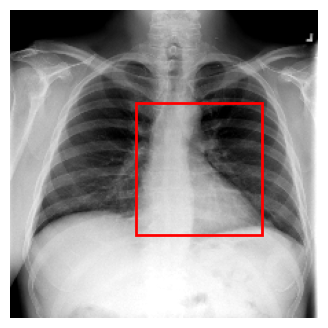

In [10]:
dataset = CardiacDatareader(train_df, aug=augment_image)
# get and preview random image
img, bbox = dataset[randint(0, len(train_df))]
img = img.detach().numpy().squeeze()
print(img.shape)

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.imshow(img, cmap="gray")
ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none'))
ax.axis("off")
plt.show()

In [11]:
class CardiacDetectionModel(LightningModule):
    def __init__(self, lr=1e-3, batch_size=8, num_workers=4):
        super().__init__()

        # hyperparameters
        self.lr = lr
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Prepare the model
        self.model = torchvision.models.resnet18(weights="DEFAULT")
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)

        # loss function
        self.loss_fn = torch.nn.MSELoss()
        self.save_hyperparameters()


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        # return optimizer
        
    def train_dataloader(self):
        train_dataset = CardiacDatareader(train_df, aug=augment_image)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        return train_loader

    def training_step(self, batch, batch_idx):
        x, label = batch
        # print(x.shape)
        label = label.float()
        pred = self(x)
        loss = self.loss_fn(pred, label)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_loss", avg_loss, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Train Loss on Epoch {self.current_epoch}: {avg_loss}")

    def val_dataloader(self):
        val_dataset = CardiacDatareader(val_df)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return val_loader

    def validation_step(self, batch, batch_idx):
        x, label = batch
        x = x.unsqueeze(1)
        label = label.float()
        pred = self(x)
        loss = self.loss_fn(pred, label)
        batch_iou_list = []
        for i in range(len(pred)):
            pred_box = pred[i].expand(1,4)
            label_box = label[i].expand(1,4)
            iou = box_iou(pred_box, label_box)
            batch_iou_list.append(iou)
        batch_iou = torch.stack(batch_iou_list).mean()
        return {"val_loss": loss, "val_iou": batch_iou}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_iou = torch.stack([x["val_iou"] for x in outputs]).mean()
        self.log("val_loss", avg_loss, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_iou", avg_iou, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Epoch {self.current_epoch}: Val Loss: {avg_loss:.2f}, Val IoU: {avg_iou:.3f}")

In [12]:
model = CardiacDetectionModel(lr=1e-3, batch_size=8, num_workers=8)

seed_everything(0)
lr_monitor = LearningRateMonitor(logging_interval="epoch")
wandb_logger = WandbLogger(project="cardiac-detection", log_model=False)
wandb_logger.watch(model)

trainer = Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=30,
    precision=16,
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    callbacks=[lr_monitor],
    fast_dev_run=False,
    logger=wandb_logger,
)

trainer.fit(model)

save_model_name = "../models/cardiac_detection_model.pt"
torch.save(model.state_dict(), save_model_name)

Global seed set to 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mctosima. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.345    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: Val Loss: 15645.16, Val IoU: 0.000
Train Loss on Epoch 0: 16480.779296875


Validation: 0it [00:00, ?it/s]

Epoch 1: Val Loss: 14831.23, Val IoU: 0.000
Train Loss on Epoch 1: 15682.0947265625


Validation: 0it [00:00, ?it/s]

Epoch 2: Val Loss: 14267.66, Val IoU: 0.000
Train Loss on Epoch 2: 15036.8330078125


Validation: 0it [00:00, ?it/s]

Epoch 3: Val Loss: 13743.79, Val IoU: 0.000
Train Loss on Epoch 3: 14414.6474609375


Validation: 0it [00:00, ?it/s]

Epoch 4: Val Loss: 13226.38, Val IoU: 0.000
Train Loss on Epoch 4: 13886.1767578125


Validation: 0it [00:00, ?it/s]

Epoch 5: Val Loss: 12893.17, Val IoU: 0.000
Train Loss on Epoch 5: 13456.4921875


Validation: 0it [00:00, ?it/s]

Epoch 6: Val Loss: 12609.22, Val IoU: 0.000
Train Loss on Epoch 6: 13119.3583984375


Validation: 0it [00:00, ?it/s]

Epoch 7: Val Loss: 12448.18, Val IoU: 0.000
Train Loss on Epoch 7: 12922.330078125


Validation: 0it [00:00, ?it/s]

Epoch 8: Val Loss: 12384.40, Val IoU: 0.000
Train Loss on Epoch 8: 12778.8369140625


Validation: 0it [00:00, ?it/s]

Epoch 9: Val Loss: 12390.27, Val IoU: 0.000
Train Loss on Epoch 9: 12729.3046875


Validation: 0it [00:00, ?it/s]

Epoch 10: Val Loss: 11610.67, Val IoU: 0.000
Train Loss on Epoch 10: 12358.53125


Validation: 0it [00:00, ?it/s]

Epoch 11: Val Loss: 10859.08, Val IoU: 0.000
Train Loss on Epoch 11: 11617.5419921875


Validation: 0it [00:00, ?it/s]

Epoch 12: Val Loss: 10365.95, Val IoU: 0.000
Train Loss on Epoch 12: 10897.466796875


Validation: 0it [00:00, ?it/s]

Epoch 13: Val Loss: 9669.91, Val IoU: 0.000
Train Loss on Epoch 13: 10265.8076171875


Validation: 0it [00:00, ?it/s]

Epoch 14: Val Loss: 9045.08, Val IoU: 0.000
Train Loss on Epoch 14: 9748.044921875


Validation: 0it [00:00, ?it/s]

Epoch 15: Val Loss: 8749.64, Val IoU: 0.000
Train Loss on Epoch 15: 9324.291015625


Validation: 0it [00:00, ?it/s]

Epoch 16: Val Loss: 8659.96, Val IoU: 0.000
Train Loss on Epoch 16: 9034.205078125


Validation: 0it [00:00, ?it/s]

Epoch 17: Val Loss: 8469.15, Val IoU: 0.000
Train Loss on Epoch 17: 8829.486328125


Validation: 0it [00:00, ?it/s]

Epoch 18: Val Loss: 8537.40, Val IoU: 0.000
Train Loss on Epoch 18: 8748.56640625


Validation: 0it [00:00, ?it/s]

Epoch 19: Val Loss: 8424.98, Val IoU: 0.000
Train Loss on Epoch 19: 8683.658203125


Validation: 0it [00:00, ?it/s]

Epoch 20: Val Loss: 7989.57, Val IoU: 0.000
Train Loss on Epoch 20: 8366.115234375


Validation: 0it [00:00, ?it/s]

Epoch 21: Val Loss: 7316.35, Val IoU: 0.000
Train Loss on Epoch 21: 7770.75146484375


Validation: 0it [00:00, ?it/s]

Epoch 22: Val Loss: 7069.33, Val IoU: 0.000
Train Loss on Epoch 22: 7223.37353515625


Validation: 0it [00:00, ?it/s]

Epoch 23: Val Loss: 6242.90, Val IoU: 0.000
Train Loss on Epoch 23: 6757.40380859375


Validation: 0it [00:00, ?it/s]

Epoch 24: Val Loss: 6193.03, Val IoU: 0.000
Train Loss on Epoch 24: 6361.3798828125


Validation: 0it [00:00, ?it/s]

Epoch 25: Val Loss: 5714.45, Val IoU: 0.000
Train Loss on Epoch 25: 6064.6875


Validation: 0it [00:00, ?it/s]

Epoch 26: Val Loss: 5665.39, Val IoU: 0.000
Train Loss on Epoch 26: 5868.7822265625


Validation: 0it [00:00, ?it/s]

Epoch 27: Val Loss: 5410.40, Val IoU: 0.000
Train Loss on Epoch 27: 5721.43212890625


Validation: 0it [00:00, ?it/s]

Epoch 28: Val Loss: 5576.02, Val IoU: 0.000
Train Loss on Epoch 28: 5642.197265625


Validation: 0it [00:00, ?it/s]

Epoch 29: Val Loss: 5523.44, Val IoU: 0.000
Train Loss on Epoch 29: 5621.1826171875


`Trainer.fit` stopped: `max_epochs=30` reached.


In [31]:
test_dataset = CardiacDatareader(val_df)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [32]:
batch = next(iter(test_loader))
x, label = batch
print(f"Input shape: {x.shape} | Label shape: {label.shape}")
print(f"Label Bbox: {label}")

Input shape: torch.Size([1, 224, 224]) | Label shape: torch.Size([1, 4])
Label Bbox: tensor([[ 89.,  54., 177., 133.]])


In [33]:
class CardiacDetectionInference(LightningModule):
    def __init__(self):
        super().__init__()
        # Prepare the model
        model = torchvision.models.resnet18(weights="DEFAULT")
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = torch.nn.Linear(in_features=512, out_features=4)
        self.model = model
    
    def forward(self, x):
        return self.model(x)

In [34]:
model = CardiacDetectionInference()
model.load_state_dict(torch.load("../models/cardiac_detection_model_better.pt"))
model.eval()
x = x.unsqueeze(0)
pred = model(x)

In [35]:
pred = pred.cpu().detach()
iou_score = box_iou(pred, label).item()
pred = pred.squeeze()
label = label.squeeze()
print(f"Pred IoU: {iou_score}")

Pred IoU: 0.8738664388656616


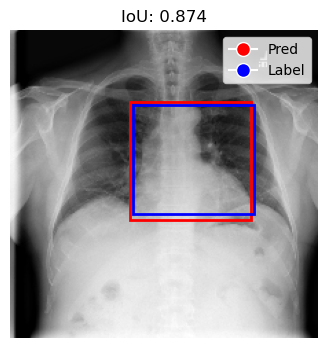

In [36]:
plt.figure(figsize=(4,4))
plt.title(f"IoU: {iou_score:.3f}")
plt.imshow(x.squeeze(), cmap="gray")
bbox_pred = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], linewidth=2, edgecolor='r', facecolor='none')
bbox_label = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], linewidth=2, edgecolor='b', facecolor='none')
plt.gca().add_patch(bbox_pred)
plt.gca().add_patch(bbox_label)
plt.axis("off")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Pred', markerfacecolor='r', markersize=10),
                     Line2D([0], [0], marker='o', color='w', label='Label', markerfacecolor='b', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()